## Compare RIP Models

As described in the README's RIP example scripts, the user can set `--rip_cache_all_preds=True`, in addition to `--debug_collect_dataset_stats=True` and cache predictions, ground truth values, per-plan confidence scores, and datapoint metadata (e.g., scene and trajectory IDs and tags) over the training and validation datasets to file.

This script provides analysis utilities that allow one to fully compare RIP configurations across number of ensemble members (K) and per-plan / per--prediction request aggregation strategies.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pylab as plt
import os
from collections import defaultdict
import numpy as np
from ysdc_dataset_api.evaluation.metrics import compute_all_aggregator_metrics
from sdc.assessment import calc_uncertainty_regection_curve, f_beta_metrics
from pprint import pprint
from sdc.cache_metadata import load_dataset_key_to_arrs, construct_full_dev_sets
from sdc.analyze_metadata import compute_dataset_results

/auto/users/neiand/workspace/uncertainty-challenge/sdc/ysdc_dataset_api/utils/transform.py:90: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  res = transform @ ph
/users/neiand/.conda/envs/uncertainty-challenge/lib/python3.8/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


## Retention Plots with Random and Optimal Baselines
As a warmup, let's load up predictions, ground truths, and per-plan scores, get weightedADE loss values as well as per--prediction request uncertainties, and run a retention analysis with Random and Optimal baselines.

In [2]:
# Specify the metadata path for the cached predictions and per-plan confidence scores.
dir_metadata_cache = 'path/to/metadata_cache'

In [3]:
# Load in predictions, ground truths, per-plan confidence scores, request IDs for each dataset
dataset_key_to_arrs = load_dataset_key_to_arrs(metadata_cache_dir=dir_metadata_cache)

# Add a field for the full__validation dataset
dataset_key_to_arrs = construct_full_dev_sets(dataset_key_to_arrs)

# Based on our desired settings, retrieve the final model predictions given:
# * k: the ensemble size (must be less than or equal to the number of members that were used to generate
#       the predictions).
# * d: number of final predictions to sample from the ensemble
# * plan_agg: per-plan aggregation strategy
# * pred_req_agg: per--prediction request aggregation strategy
# * dataset_key: dataset to generate predictions, conf scores, etc. for
# * dataset_key_to_arrs_dict: contains cached data
# * n_pred_per_model: should be the same number as was set in the config parameter --rip_samples_per_model
#.      when caching the predictions
# * retention_column: metric on which we compute retention
# * return_preds_and_scores: boolean, if True, do not compute losses and instead return preds and 
#       scores for use with submission protobuf or more downstream analysis, as in our case.

# For more info, see sdc/analyze_metadata.py.

(model_preds, plan_conf_scores, pred_req_conf_scores, 
 request_ids, is_ood_arr) = (
    compute_dataset_results(
        k=5, d=5, plan_agg='MA', pred_req_agg='MA', 
        dataset_key='full__validation',
        dataset_key_to_arrs_dict=dataset_key_to_arrs, 
        n_pred_per_model=10, 
        retention_column='weightedADE', 
        return_preds_and_scores=True))

# Compute all metrics using our predictions.
metrics_dict = compute_all_aggregator_metrics(
    per_plan_confidences=plan_conf_scores,
    predictions=model_preds,
    ground_truth=dataset_key_to_arrs['full__validation']['gt_trajectories'],
    metric_name='weightedADE')

Using 5 models in ensemble.
Preds shape:  (465421, 50, 25, 2)
Conf scores shape:  (465421, 50, 5)
Aggregated plan confidence scores using aggregator MA to shape (465421, 50)
Filtered to top 5 plans.
Top model preds shape: (465421, 5, 25, 2)
Top model per-plan conf scores shape: (465421, 5)
Aggregated pred-req confidence scores from scores of the top 5 plans using aggregator MA to shape (465421,).
Returning predictions and scores.


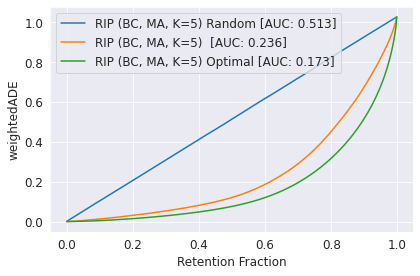

Saved to path /scratch-ssd/neiand/sdc/retention_plots_with_baselines_jul15/SDC - Ret - BC_MA_K5__full__dev_with_baselines.pdf.


In [12]:
from plot_retention_curves import plot_retention_curve_with_baselines

model_key = 'BC, MA, K=5'
fig = plot_retention_curve_with_baselines(
    uncertainty_scores=(-pred_req_conf_scores),
    losses=metrics_dict['weightedADE'],
    model_key=model_key,
    metric_name='weightedADE')

In [ ]:
# Save the plot to a desired directory.
# See sdc/metrics.py + plot_retention_curves.py for the full retention plot utilities.

retention_plot_path = f'/path/to/retention_plots'
os.makedirs(retention_plot_path, exist_ok=True)
ret_plot_file_path = os.path.join(
    retention_plot_path, f'{model_key}__full_validation__retention_with_baselines.pdf')
fig.savefig(ret_plot_file_path, dpi=300, format='pdf')
print(f'Saved to path {ret_plot_file_path}.')

## Retention Plots: Plot Several Methods Jointly

In [13]:
# Plot retention curves for BC and DIM, K = 1 or 5, MA aggregation
bc_metadata_cache = '/path/to/bc/model'
dim_metadata_cache = '/path/to/dim/model'

bc_dataset_key_to_arrs = load_dataset_key_to_arrs(metadata_cache_dir=bc_metadata_cache)
bc_dataset_key_to_arrs = construct_full_dev_sets(bc_dataset_key_to_arrs)
dim_dataset_key_to_arrs = load_dataset_key_to_arrs(metadata_cache_dir=dim_metadata_cache)
dim_dataset_key_to_arrs = construct_full_dev_sets(dim_dataset_key_to_arrs)

dataset_keys = ['full__validation', 'full__test']
results_dict = defaultdict(dict)

for model_backbone, dataset_key_to_arrs in zip(
    ['bc', 'dim'], [bc_dataset_key_to_arrs, dim_dataset_key_to_arrs]):
    for dataset_key in dataset_keys:
        for agg_method in ['MA']:
            for k in [1, 5]:
                print(model_backbone, agg_method, k, dataset_key)
                (model_preds, plan_conf_scores, pred_req_conf_scores, 
                     request_ids, is_ood_arr) = (
                        compute_dataset_results(
                            k=k, d=5, plan_agg=agg_method, pred_req_agg=agg_method, 
                            dataset_key=dataset_key,
                            dataset_key_to_arrs_dict=dataset_key_to_arrs, 
                            n_pred_per_model=10, 
                            retention_column='weightedADE', 
                            return_preds_and_scores=True))
                print('Retrieved preds.')
                metrics_dict = compute_all_aggregator_metrics(
                    per_plan_confidences=plan_conf_scores,
                    predictions=model_preds,
                    ground_truth=dataset_key_to_arrs[dataset_key]['gt_trajectories'],
                    metric_name='weightedADE')
                print('Computed base metrics.')
                retention_curve = calc_uncertainty_regection_curve(
                    errors=metrics_dict['weightedADE'], uncertainty=(-pred_req_conf_scores))
                auc = retention_curve.mean()
                print('Finished computing retention curve + R-AUC.')
                print('\n')

                model_key = f'{model_backbone.upper()}, {agg_method}, K={k}'
                results_dict[dataset_key][model_key] = (auc, retention_curve)

ood__validation
moscow__test
moscow__validation
moscow__validation
ood__validation
ood__test
ood__test
moscow_precip__test
ood__validation
moscow_precip__test
moscow_precip__test
ood__test
moscow__test
moscow__validation
moscow__validation
moscow__test
moscow__test
ood__test
moscow_precip__test
ood__validation
ood__validation
moscow__test
moscow__validation
moscow__validation
ood__validation
ood__test
ood__test
moscow_precip__test
ood__validation
moscow_precip__test
moscow_precip__test
ood__test
moscow__test
moscow__validation
moscow__validation
moscow__test
moscow__test
ood__test
moscow_precip__test
ood__validation
bc MA 1 full__validation
Using 1 models in ensemble.
Preds shape:  (465421, 10, 25, 2)
Conf scores shape:  (465421, 10, 1)
Aggregated plan confidence scores using aggregator MA to shape (465421, 10)
Filtered to top 5 plans.
Top model preds shape: (465421, 5, 25, 2)
Top model per-plan conf scores shape: (465421, 5)
Aggregated pred-req confidence scores from scores of the top

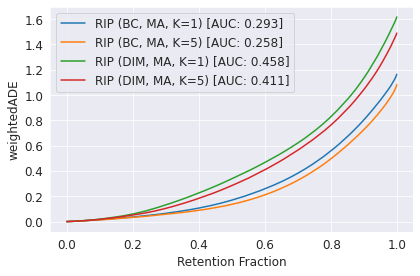

In [16]:
# Plot the RIP variants on the full evaluation dataset.

dataset_key = 'full__test'
model_key_to_auc_and_curve = results_dict[dataset_key]

plot_retention_curves_from_dict(
    model_key_to_auc_and_curve=model_key_to_auc_and_curve,
    metric_name='weightedADE')

### Convert Raw Predictions to Submission File

In [ ]:
from ysdc_dataset_api.evaluation import Submission, object_prediction_from_model_output, save_submission_proto

model_backbone = 'bc'
dir_metadata_cache = '/path/to/metadata_cache'
dataset_key_to_arrs = load_dataset_key_to_arrs(metadata_cache_dir=dir_metadata_cache)
dataset_key_to_arrs = construct_full_dev_sets(dataset_key_to_arrs)

# Construct submission file from predictions
(model_preds, plan_conf_scores, pred_req_conf_scores,
 request_ids, is_ood_arr) = (
    compute_dataset_results(
        k=5, d=5, plan_agg='MA', pred_req_agg='MA', 
        dataset_key='full__validation',
        dataset_key_to_arrs_dict=dataset_key_to_arrs, 
        n_pred_per_model=10, 
        retention_column='weightedADE', 
        return_preds_and_scores=True))

In [ ]:
with open(os.path.join(dir_metadata_cache, 'request.tsv')) as f:
    request_df = pd.read_csv(f, sep='\t')

In [ ]:
request_df_dev = request_df[request_df['dataset_key'].isin([
    'ood__validation', 'moscow__validation'])]
scene_ids = request_df_dev['scene_ids']
df_request_ids = request_df_dev['request_ids']
assert (request_ids == df_request_ids).all()  # Request IDs should match from metadata and full cached array.

In [ ]:
from ysdc_dataset_api.evaluation.metrics import _softmax_normalize

submission = Submission()

for preds, plan_confs, pred_req_conf, req_id, scene_id, is_ood in zip(
    model_preds, plan_conf_scores, pred_req_conf_scores, request_ids, scene_ids, is_ood_arr):
    data_item_output = {
        'predictions_list': [preds[i] for i in range(preds.shape[0])],
        'plan_confidence_scores_list': _softmax_normalize(plan_confs).tolist(),
        'pred_request_confidence_score': -(pred_req_conf.item())
    }
    proto = object_prediction_from_model_output(
        track_id=req_id,
        scene_id=scene_id,
        model_output=data_item_output,
        is_ood=is_ood)

    submission.predictions.append(proto)

In [ ]:
len(submission.predictions)  # Should be 465421

In [ ]:
save_submission_proto('/path/to/dev_moscow_and_ood_submission.pb', submission=submission)